In [1]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

images_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/frames_copy'

## 1. Rename images from frameX to video_frameX

In [ ]:
# Images contains folders of images. Each folder is a video and each image is a frame and named frameX.jpg
  # Rename all images to be <video_name>_<original_image_name>.jpg
# Get all folders in images_folder
folders = os.listdir(images_folder)
for folder in folders:
    print('processing folder: ' + folder)
    # Get all images in folder
    images = os.listdir(os.path.join(images_folder, folder))
    for image in images:
        # Rename image
        shutil.move(os.path.join(images_folder, folder, image), os.path.join(images_folder, folder, folder + '_' + image))


## 2. Remove Text

In [34]:
def plot_img(image, result, mask):
    plt.figure(figsize=(30, 25))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original image')
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Result')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

#### 2.1 Inpainting
1. Turns image to greyscale
2. Detects pixels that are bright and considers them as text

In [ ]:


THRESHOLD = 180 # pixels brighter than this will be considered text

def inpaint(image_path, inp_radius=15):
  # Load the image
  image = cv2.imread(image_path)

  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Use thresholding to create a mask for the text
  # You will need to adjust the threshold value based on your specific image
  _, mask = cv2.threshold(gray, THRESHOLD, 255, cv2.THRESH_BINARY)

  # Inpaint the original image using the mask
  result = cv2.inpaint(image, mask, inp_radius, cv2.INPAINT_TELEA)
  
  return result

test_image1 = os.path.join(images_folder, "gfp_bahamas1", f'gfp_bahamas1_frame540.jpg')
test_image2 = os.path.join(images_folder, "gfp_palau1", f'gfp_palau1_frame990.jpg')
inpaint(test_image1)
inpaint(test_image2)

#### 2.2 Median Filter
Run median filter over the detected text

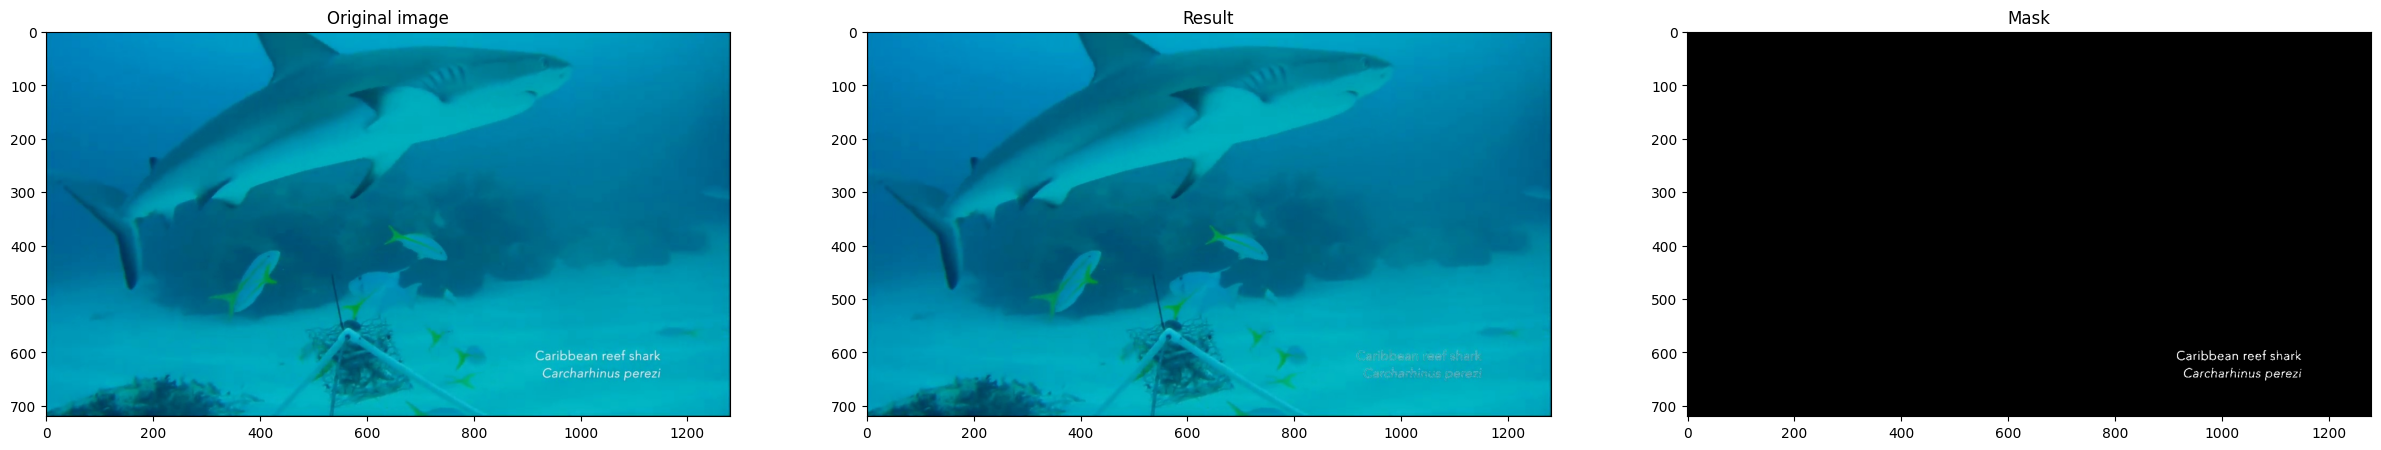

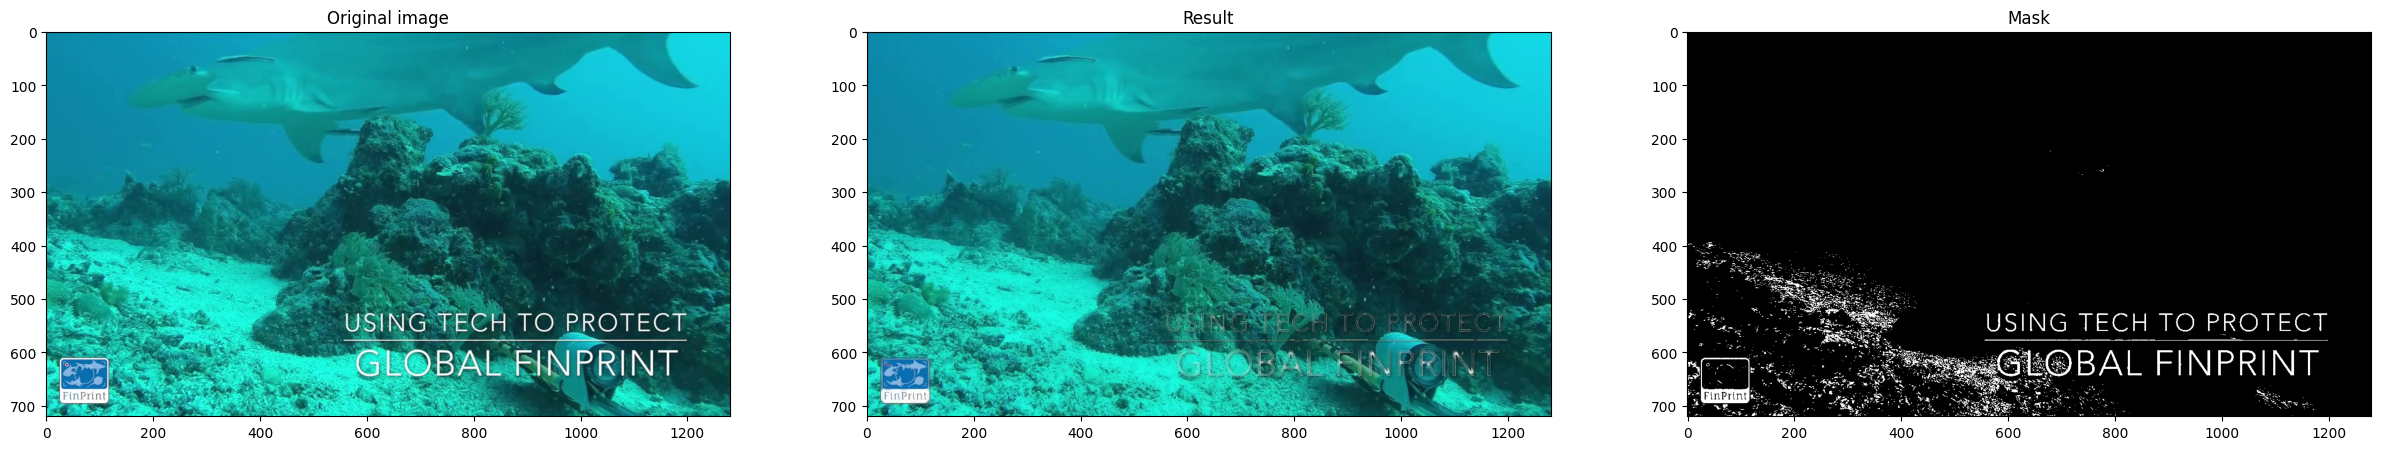

In [55]:
def median_filter(image_path, filter_size=13):
  # get image and text mask
  image = cv2.imread(image_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(gray, THRESHOLD, 255, cv2.THRESH_BINARY)

  # apply median filter
  median = cv2.medianBlur(image, filter_size)

  # masked median
  masked_median = np.where(mask[:,:,None] == 255, median, image)

  # Display result and original imag
  plt.figure(figsize=(30, 25))
  plt.subplot(1, 3, 1)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title('Original image')
  plt.subplot(1, 3, 2)
  plt.imshow(cv2.cvtColor(masked_median, cv2.COLOR_BGR2RGB))
  plt.title('Result')
  plt.subplot(1, 3, 3)
  plt.imshow(mask, cmap='gray')
  plt.title('Mask')

  cv2.imwrite(f'./median_filter_test/result_{filter_size}.png', masked_median)

median_filter(test_image1)
median_filter(test_image2)

In [ ]:
for i in range(1, 10):
  # inpaint(test_image, i)
  median_filter(test_image1, i*2+1)

#### 2.3 Firstly cover text pixels with average outside text, then inpaint

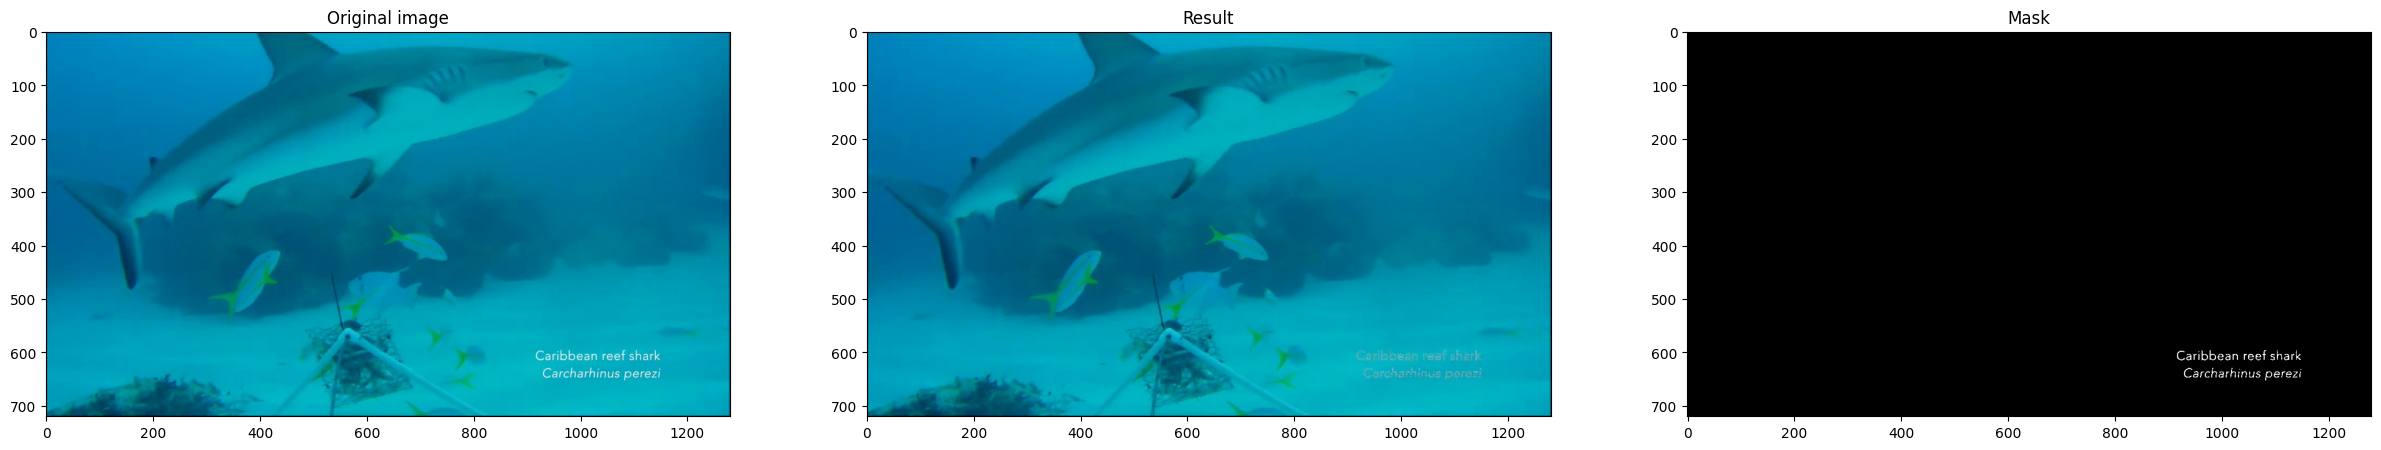

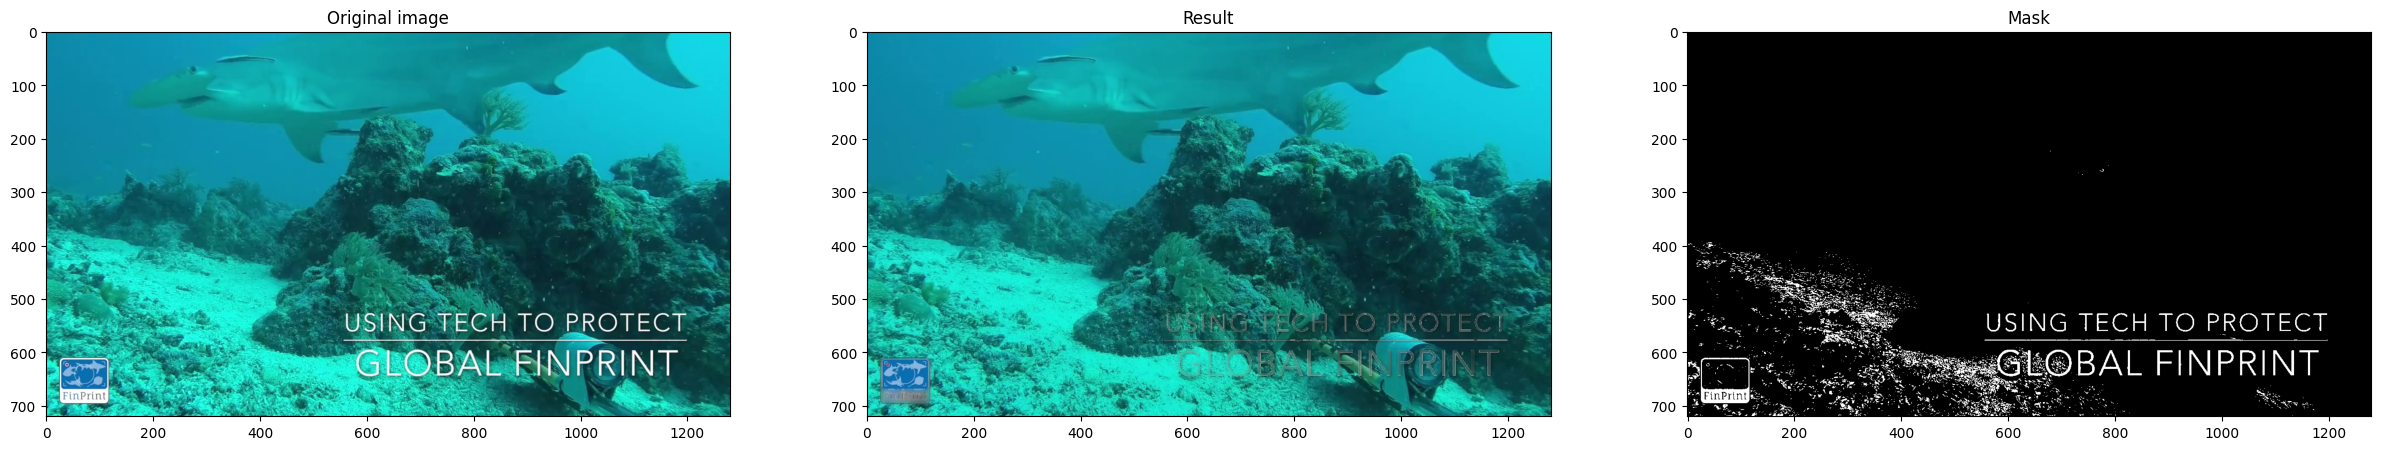

In [28]:
def average_then_process(image_path, radius=15):
  # Load the image
  image = cv2.imread(image_path)

  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Use thresholding to create a mask for the text
  # You will need to adjust the threshold value based on your specific image
  _, mask = cv2.threshold(gray, THRESHOLD, 255, cv2.THRESH_BINARY)

  # Calculate mean_val which is the mean of the pixels in the original image that are not text
  # (so that are not 255 in the mask)
  mean_val = np.mean(image[mask == 0])

  # Set value of text pixels (detected by the mask) to the mean value and save result to variable temp_result
  temp_result = image.copy()
  temp_result[mask > 0] = mean_val

  result = cv2.inpaint(temp_result, mask, radius, cv2.INPAINT_TELEA)

  # Display result and original imag
  plt.figure(figsize=(30, 25))
  plt.subplot(1, 3, 1)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title('Original image')
  plt.subplot(1, 3, 2)
  plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  plt.title('Result')
  plt.subplot(1, 3, 3)
  plt.imshow(mask, cmap='gray')
  plt.title('Mask')

  # Save image in ./inpaint_test
  # cv2.imwrite(f'./inpaint_test_telea/result_{inp_radius}.png', result)

  # Save or display the result
  # cv2.imwrite('/mnt/data/cleaned_image.png', result)

test_image1 = os.path.join(images_folder, "gfp_bahamas1", f'gfp_bahamas1_frame540.jpg')
test_image2 = os.path.join(images_folder, "gfp_palau1", f'gfp_palau1_frame990.jpg')
average_then_process(test_image1)
average_then_process(test_image2)

#### 2.4 Just add a box = average of the pixels around the text

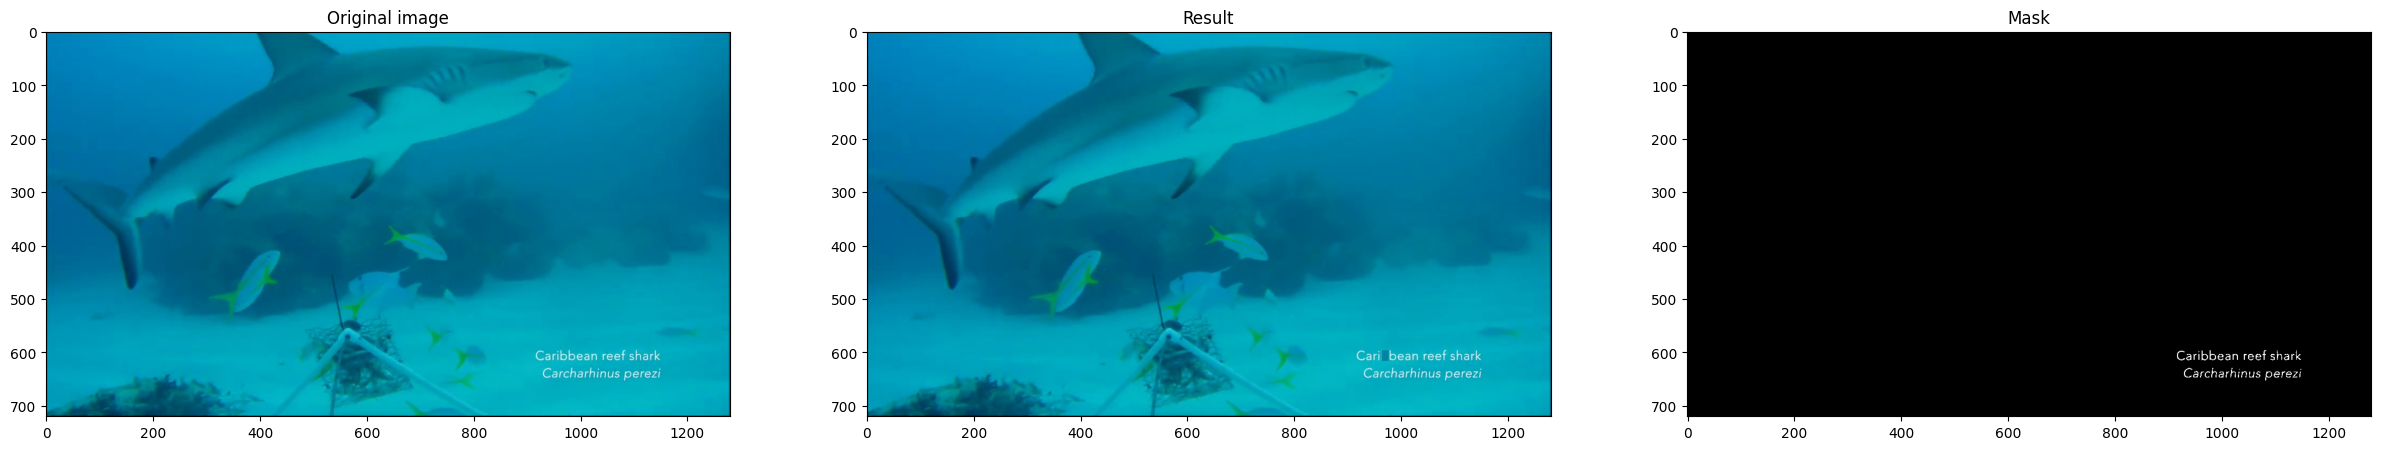

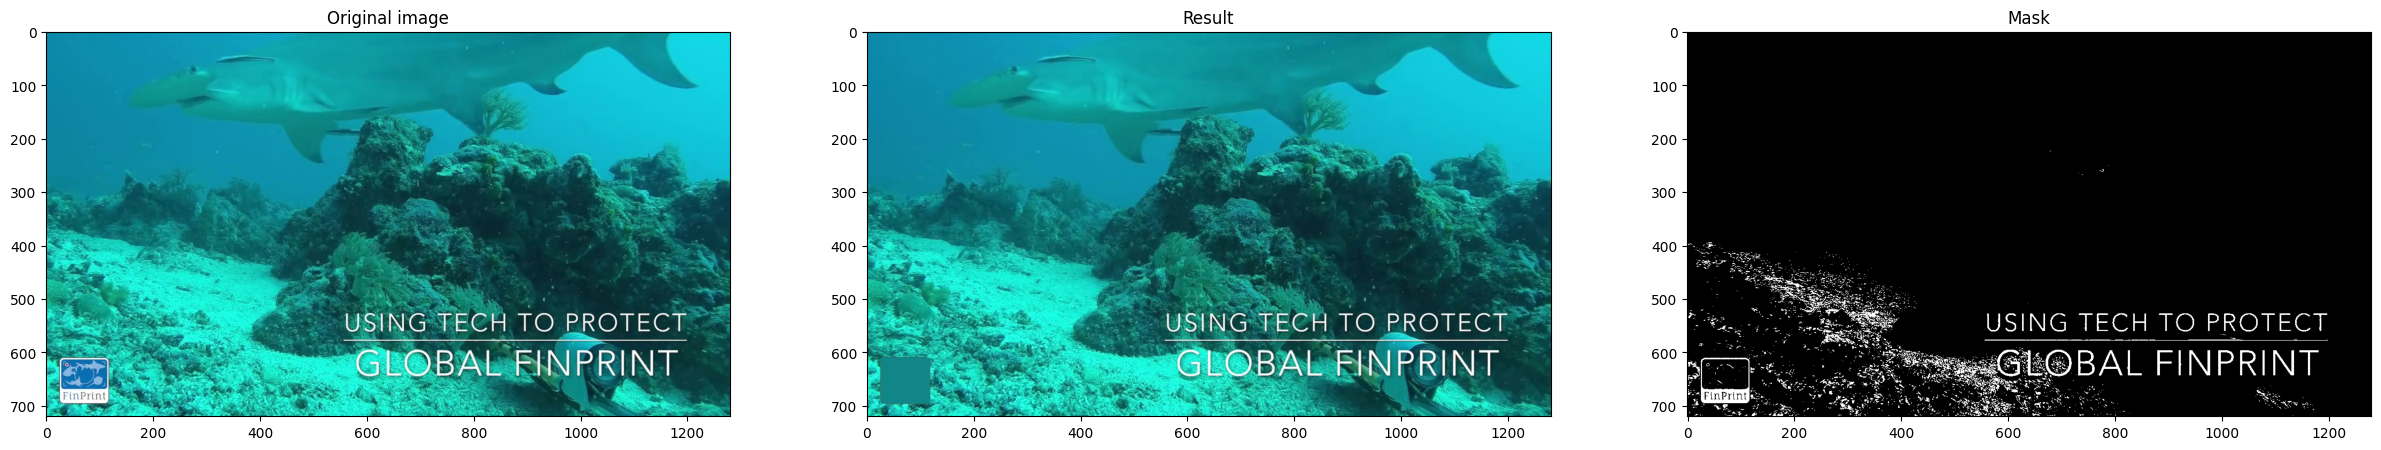

In [14]:
def add_colored_box(image_path, THRESHOLD=180):
    # get image and text mask
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, THRESHOLD, 255, cv2.THRESH_BINARY)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour in the mask is the text
    largest_contour = max(contours, key=cv2.contourArea)
    # Calculate bounding box for the text
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculate the average color of the pixels outside the mask
    # Create an inverted mask
    inverted_mask = cv2.bitwise_not(mask)
    # Use the inverted mask to select pixels outside the text area
    outside_text = cv2.bitwise_and(image, image, mask=inverted_mask)
    # Calculate the mean color of the pixels outside the text area
    mean_val = cv2.mean(outside_text, mask=inverted_mask)[:3]

    # Draw a rectangle over the text area
    result = image.copy()
    cv2.rectangle(result, (x, y), (x + w, y + h), mean_val, -1)

    # Display the original image with the colored box
    plt.figure(figsize=(30, 25))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original image')
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Result')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

add_colored_box(test_image1)
add_colored_box(test_image2)

### BULK IT!

In [38]:
# For each image in each folder of images_folder, apply inpaint and save result in inpainted_folder
inpainted_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/frames_inpainted'
folders = os.listdir(images_folder)
for folder in folders:
    print('processing folder: ' + folder)
    # Create folder
    os.mkdir(os.path.join(inpainted_folder, folder))
    # Get all images in folder
    images = os.listdir(os.path.join(images_folder, folder))
    for image in images:
        # Apply inpaint
        result = inpaint(os.path.join(images_folder, folder, image))
        # Save result in inpainted_folder
        cv2.imwrite(os.path.join(inpainted_folder, folder, image), result)

processing folder: gfp_maldives1
processing folder: gfp_kiribati1
processing folder: gfp_rand6
processing folder: gfp_png1
processing folder: gfp_nwa1
processing folder: gfp_palau1
processing folder: gfp_madagascar1
processing folder: gfp_tobago1
processing folder: gfp_rand1
processing folder: gfp_ferdinand1
processing folder: gfp_caledonia1
processing folder: gfp_rand5
processing folder: gfp_nwa2
processing folder: gfp_rand11
processing folder: gfp_tonga1
processing folder: gfp_polynesia1
processing folder: gfp_rand2
processing folder: gfp_rand8
processing folder: gfp_tiger1
processing folder: gfp_cook1
processing folder: gfp_niue1
processing folder: gfp_bahamas2
processing folder: gfp_barbados1
processing folder: gfp_samoa1
processing folder: gfp_rand7
processing folder: gfp_jamaica1
processing folder: gfp_solomon1
processing folder: gfp_belize1
processing folder: gfp_caicos1
processing folder: gfp_bahamas1
processing folder: gfp_hawaii1
processing folder: gfp_mozambique1
processing 

## 3. Remove Logo

#### 3.1 Calculate image isze

In [39]:
# For each image in each folder of images_folder, check the size and plot a histogram showing the frequency of both width and height
folders = os.listdir(images_folder)
widths = []
heights = []
for folder in folders:
    print('processing folder: ' + folder)
    # Get all images in folder
    images = os.listdir(os.path.join(images_folder, folder))
    for image in images:
        # Get image size
        img = cv2.imread(os.path.join(images_folder, folder, image))
        h, w, _ = img.shape
        widths.append(w)
        heights.append(h)
print(f'total images {len(widths)}')

processing folder: gfp_maldives1
processing folder: gfp_kiribati1
processing folder: gfp_rand6
processing folder: gfp_png1
processing folder: gfp_nwa1
processing folder: gfp_palau1
processing folder: gfp_madagascar1
processing folder: gfp_tobago1
processing folder: gfp_rand1
processing folder: gfp_ferdinand1
processing folder: gfp_caledonia1
processing folder: gfp_rand5
processing folder: gfp_nwa2
processing folder: gfp_rand11
processing folder: gfp_tonga1
processing folder: gfp_polynesia1
processing folder: gfp_rand2
processing folder: gfp_rand8
processing folder: gfp_tiger1
processing folder: gfp_cook1
processing folder: gfp_niue1
processing folder: gfp_bahamas2
processing folder: gfp_barbados1
processing folder: gfp_samoa1
processing folder: gfp_rand7
processing folder: gfp_jamaica1
processing folder: gfp_solomon1
processing folder: gfp_belize1
processing folder: gfp_caicos1
processing folder: gfp_bahamas1
processing folder: gfp_hawaii1
processing folder: gfp_mozambique1
processing 

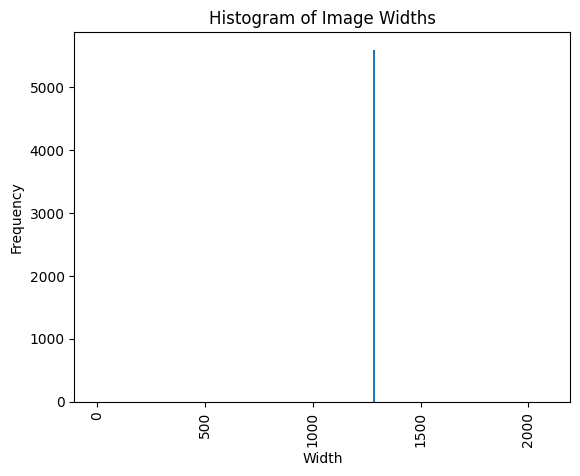

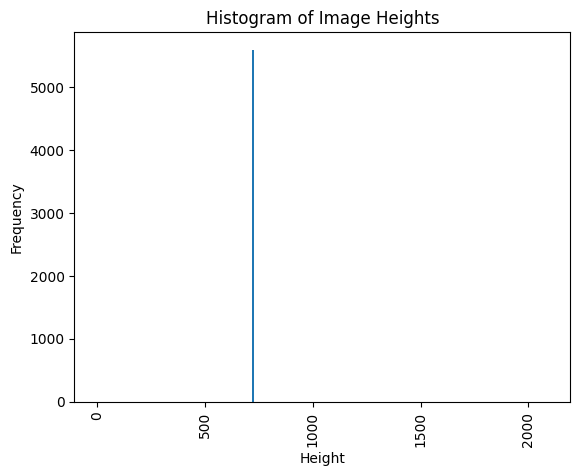

In [41]:
# plot histogram of widths and heights
# Plot histogram for width
plt.hist(widths, bins=range(0, 2100, 10))
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Histogram of Image Widths')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Plot histogram for height
plt.hist(heights, bins=range(0, 2100, 10))
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Histogram of Image Heights')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

This shows us that all images have same size, so we can assume the logos are in the same size

#### Remove Logo

In [18]:
static_logos = {
  "gfp_belize1": {
    "loc": "BL",
    "size": "s"
  },
  "gfp_rand3": {
    "loc": "TR",
    "size": "m"
  },
  "gfp_rand6": {
    "loc": "TL",
    "size": "s"
  },
  "gfp_tiger1": {
    "loc": "BL",
    "size": "s"
  },
  "gfp_rand7": {
    "loc": "TL",
    "size": "s"
  },
  "gfp_maldives1": {
    "loc": "BL",
    "size": "s"
  },
  "gfp_palau1": {
    "loc": "BL",
    "size": "s"
  },
  "gfp_rand8": {
    "loc": "TR",
    "size": "m"
  },
}

max_width = 1280
max_height = 720
offset = 130

crops = {
  "BL": {
    "s": {
      "xmin": offset,
      "xmax": max_width,
      "ymin": 0,
      "ymax": max_height - offset
    }
  },
  "TL": {
    "s": {
      "xmin": offset,
      "xmax": max_width,
      "ymin": offset,
      "ymax": max_height
    }
  },
  "TR": {
    "m": {
      "xmin": 0,
      "xmax": max_width - (offset + 10),
      "ymin": (offset + 10),
      "ymax": max_height
    }
  }

}

In [10]:
import cv2
import albumentations as A

def crop_and_adjust_bbox(image_path, bboxes):
    """
    Crop an image and adjust bounding boxes accordingly.

    Parameters:
    - image_path: Path to the image.
    - bboxes: A dict of bounding boxes before cropping, in the format [(x_min, y_min, x_max, y_max, label), ...].
              Coordinates should be normalized ([0, 1] range).
    - crop_coordinates: The crop coordinates (x_min, y_min, x_max, y_max), not normalized.

    Returns:
    - cropped_image: The cropped image.
    - adjusted_bboxes: The adjusted bounding boxes after cropping.
    """

    # get first parent directory
    video_name = os.path.basename(os.path.dirname(image_path))
    logo_location = static_logos[video_name]['loc']
    logo_size = static_logos[video_name]['size']

    # Load the image
    image = cv2.imread(image_path)

    # Define the crop area. Crop_coordinates is a dict
    print(video_name, logo_location, logo_size)
    crop_coordinates = crops[logo_location][logo_size]
    x_min = crop_coordinates['xmin']
    x_max = crop_coordinates['xmax']
    y_min = crop_coordinates['ymin']
    y_max = crop_coordinates['ymax']
    print(x_min, x_max, y_min, y_max)

    # Define the transformation
    bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}
    transform = A.Compose([
        A.Crop(x_min=int(x_min), y_min=int(y_min), x_max=int(x_max), y_max=int(y_max), p=1.0),
    ], bbox_params=bbox_params)

    labels = np.ones(len(bboxes))

    # Apply the transformation
    transformed = transform(image=image, bboxes=bboxes, labels=labels)
    cropped_image = transformed['image']
    adjusted_bboxes = transformed['bboxes']

    return cropped_image, adjusted_bboxes

In [4]:
annotations_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/annotations_sharktrack'
def get_annotations(image_path):
  video_name = os.path.basename(os.path.dirname(image_path))
  img_id = os.path.basename(image_path)
  annotations_path = os.path.join(annotations_folder, f'{video_name}.csv')
  annotations_df = pd.read_csv(annotations_path)
  return annotations_df

def get_bboxes(image_path):
  img_id = os.path.basename(image_path)
  annotations_df = get_annotations(image_path)
  bboxes = annotations_df.loc[annotations_df.Filename == img_id, 'xmin ymin xmax ymax'.split()].values
  return bboxes

gfp_rand8 TR m
0 1140 140 720
[[191 323 373 472]]
[[191.0, 183.0, 373.0, 332.0]]
image size (580, 1140, 3)


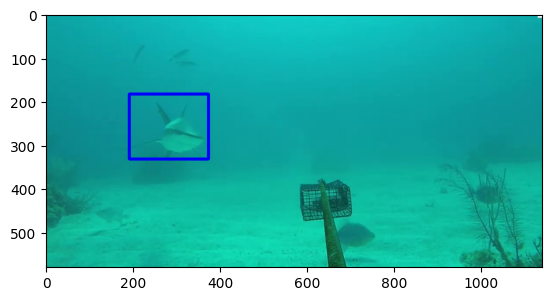

In [19]:
# video = 'gfp_rand7'
# test_folder = f'/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/frames/{video}/'
# test_image = 'gfp_rand7_frame780.jpg'
video = 'gfp_rand8'
test_folder = f'/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/frames/{video}/'
test_image = 'gfp_rand8_frame150.jpg'
# video = 'gfp_belize1'
# test_folder = f'/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/frames/{video}/'
# test_image = 'gfp_belize1_frame1920.jpg'
test_image_path = os.path.join(test_folder, test_image)
bboxes = get_bboxes(test_image_path)

from utils import plot_img, draw_rect

annotations_df = get_annotations(test_image_path)
bboxes = get_bboxes(test_image_path)
# plot_img(test_image, test_folder, annotations_df, bbox=True)
aug_image, aug_bboxes = crop_and_adjust_bbox(test_image_path, bboxes)
aug_bboxes = [list(bbox) for bbox in aug_bboxes]
print(bboxes)
print(aug_bboxes)
aug_image = draw_rect(aug_image, aug_bboxes)
print('image size', aug_image.shape)
plt.imshow(cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB))
# plot_img(aug_image, test_folder, annotations_df, bbox=True)

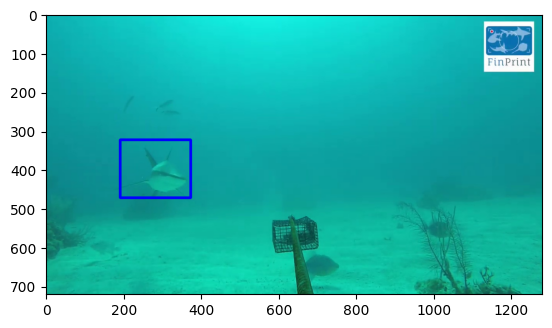

In [20]:
plot_img(test_image, test_folder, annotations_df, bbox=True)

#### Bulk ITTTTTTTT

In [44]:
annotation_output_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/annotations_sharktrack_no_logo'
image_output_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/frames_no_logo'

for video in list(static_logos.keys())[:1]:
  annotations = {
    "Filename": [],
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
    "Genus": [],
    "Species": [],
  }

  assert video in os.listdir(images_folder)
  print(f'Processing {video}')
  video_folder = os.path.join(images_folder, video)
  images = os.listdir(video_folder)
  annotations_df = get_annotations(os.path.join(video_folder, images[0]))
  aug_image_folder = os.path.join(image_output_folder, video)
  os.mkdir(aug_image_folder)
  for image in images:
    image_path = os.path.join(video_folder, image)
    bboxes = get_bboxes(image_path)

    
    
    aug_image, aug_bboxes = crop_and_adjust_bbox(image_path, bboxes)
    aug_bboxes = [list(bbox) for bbox in aug_bboxes]
    cv2.imwrite(os.path.join(aug_image_folder, image), aug_image)

    # Keep previous information
    annotations['Genus'] += annotations_df.loc[annotations_df.Filename == image, 'Genus'].values or []
    annotations['Species'] += annotations_df.loc[annotations_df.Filename == image, 'Species'].values or []
    annotations['Filename'] += [f'{video}_{image}'] * len(aug_bboxes) or []
    annotations['xmin'] += [bbox[0] for bbox in aug_bboxes]
    annotations['ymin'] += [bbox[1] for bbox in aug_bboxes]
    annotations['xmax'] += [bbox[2] for bbox in aug_bboxes]
    annotations['ymax'] += [bbox[3] for bbox in aug_bboxes]

  annotations_df = pd.DataFrame(annotations)
  # Add empty column Augmentation
  annotations_df['Augmentation'] = ''
  annotations_df['Source'] = video

  # Save annotations
  path = os.path.join(annotation_output_folder, f'{video}.csv')
  print(f'Saving annotations in {path}')
  annotations_df.to_csv(path, index=False)


Processing gfp_belize1
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590


/tmp/ipykernel_537851/3183758861.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  annotations['Genus'] += annotations_df.loc[annotations_df.Filename == image, 'Genus'].values or []
/tmp/ipykernel_537851/3183758861.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  annotations['Species'] += annotations_df.loc[annotations_df.Filename == image, 'Species'].values or []
/tmp/ipykernel_537851/3183758861.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  annotations['Genus'] += annotations_df.loc[annotations_df.Filename == image, 'Genus'].values or []
/tmp/ipykern

gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590


/tmp/ipykernel_537851/3183758861.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  annotations['Genus'] += annotations_df.loc[annotations_df.Filename == image, 'Genus'].values or []
/tmp/ipykernel_537851/3183758861.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  annotations['Species'] += annotations_df.loc[annotations_df.Filename == image, 'Species'].values or []
/tmp/ipykernel_537851/3183758861.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  annotations['Genus'] += annotations_df.loc[annotations_df.Filename == image, 'Genus'].values or []
/tmp/ipykern

gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590
gfp_belize1 BL s
130 1280 0 590


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [33]:
!ls /vol/biomedic3/bglocker/ugproj2324/fv220/datasets/youtube_bruvs/annotations_sharktrack_no_logo/